# Classification Toko Baju using RNN
## Importing libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)
df.dropna(inplace=True)

In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [ ]:
# Preprocessing: tokenisasi manual dan buat vocab
def simple_tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hilangkan simbol
    return text.split()

texts = df['Review Text'].astype(str).tolist()
labels = df['Recommended IND'].tolist()

tokenized = [simple_tokenizer(t) for t in texts]
vocab = {}
for tokens in tokenized:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab) + 1  # padding = 0

def encode(tokens):
    return [vocab[token] for token in tokens if token in vocab]

encoded_texts = [torch.tensor(encode(t)) for t in tokenized]
padded_texts = pad_sequence(encoded_texts, batch_first=True)
labels = torch.tensor(labels)


In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(padded_texts, labels, test_size=0.2, random_state=42)

# Dataset & DataLoader
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(ReviewDataset(X_test, y_test), batch_size=32)


In [ ]:
# RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

model = RNNClassifier(len(vocab), 64, 128, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Hitung akurasi training
        preds = (torch.sigmoid(output) > 0.5).int()
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_losses.append(epoch_loss / len(train_loader))
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # Validation loss dan akurasi
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch).squeeze()
            loss = criterion(output, y_batch.float())
            test_loss += loss.item()

            preds = (torch.sigmoid(output) > 0.5).int()
            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | "
          f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch  1 | Train Loss: 0.4813 | Test Loss: 0.4686 | Train Acc: 0.8154 | Test Acc: 0.8220
Epoch  2 | Train Loss: 0.4763 | Test Loss: 0.4687 | Train Acc: 0.8172 | Test Acc: 0.8220
Epoch  3 | Train Loss: 0.4794 | Test Loss: 0.4729 | Train Acc: 0.8161 | Test Acc: 0.8187
Epoch  4 | Train Loss: 0.4787 | Test Loss: 0.4708 | Train Acc: 0.8165 | Test Acc: 0.8218
Epoch  5 | Train Loss: 0.5177 | Test Loss: 0.5790 | Train Acc: 0.7806 | Test Acc: 0.6898
Epoch  6 | Train Loss: 0.4838 | Test Loss: 0.4731 | Train Acc: 0.8149 | Test Acc: 0.8220
Epoch  7 | Train Loss: 0.4776 | Test Loss: 0.4652 | Train Acc: 0.8172 | Test Acc: 0.8220
Epoch  8 | Train Loss: 0.4771 | Test Loss: 0.4698 | Train Acc: 0.8172 | Test Acc: 0.8220
Epoch  9 | Train Loss: 0.4774 | Test Loss: 0.4699 | Train Acc: 0.8172 | Test Acc: 0.8220
Epoch 10 | Train Loss: 0.4784 | Test Loss: 0.4691 | Train Acc: 0.8172 | Test Acc: 0.8220


In [ ]:
# Evaluation (Testing Set)
model.eval()
y_pred_test, y_true_test = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = torch.sigmoid(model(X_batch).squeeze())
        preds = (output > 0.5).int()
        y_pred_test.extend(preds.tolist())
        y_true_test.extend(y_batch.tolist())

# Eval on Train Set juga
y_pred_train, y_true_train = [], []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        output = torch.sigmoid(model(X_batch).squeeze())
        preds = (output > 0.5).int()
        y_pred_train.extend(preds.tolist())
        y_true_train.extend(y_batch.tolist())

# Hitung metrik
train_acc = accuracy_score(y_true_train, y_pred_train)
test_acc = accuracy_score(y_true_test, y_pred_test)
prec = precision_score(y_true_test, y_pred_test)
rec = recall_score(y_true_test, y_pred_test)
f1 = f1_score(y_true_test, y_pred_test)
auc = roc_auc_score(y_true_test, y_pred_test)

# Tampilkan hasil
print(f"Akurasi Training Set : {train_acc*100:.2f}%")
print(f"Akurasi Testing Set  : {test_acc*100:.2f}%")
print(f"Presisi              : {prec:.2f}")
print(f"Recall               : {rec:.2f}")
print(f"F1 Score             : {f1:.2f}")
print(f"AUC Score            : {auc:.2f}")


Akurasi Training Set : 81.72%
Akurasi Testing Set  : 82.20%
Presisi              : 0.82
Recall               : 1.00
F1 Score             : 0.90
AUC Score            : 0.50


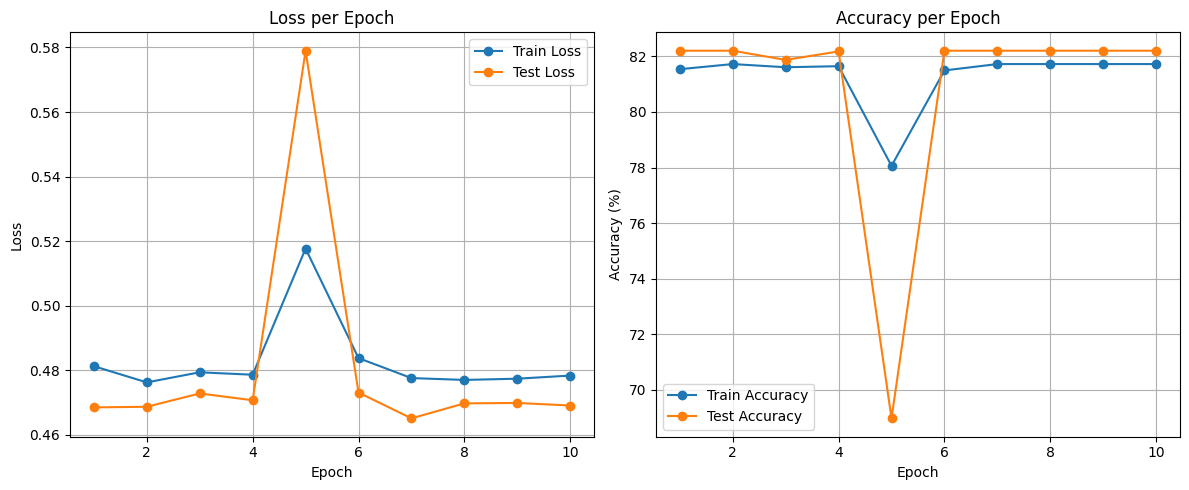

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label='Train Accuracy', marker='o')
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


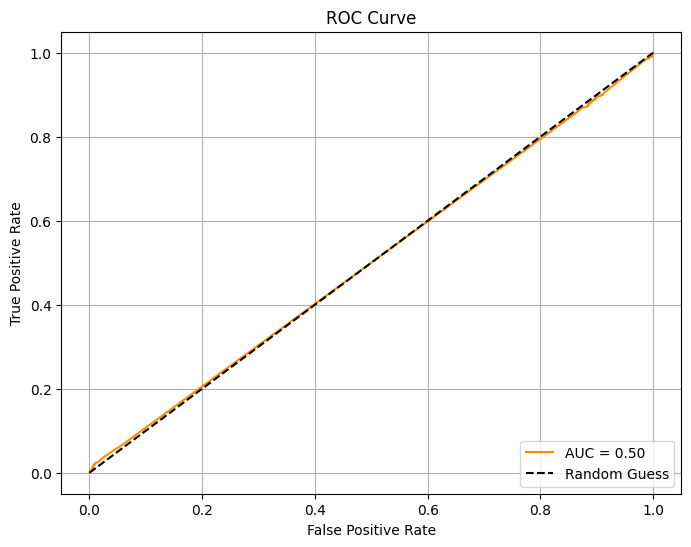

In [ ]:
from sklearn.metrics import roc_curve

# ROC Curve (pakai probabilitas, bukan thresholded predictions)
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        output = torch.sigmoid(model(X_batch).squeeze())
        y_scores.extend(output.tolist())

# Hitung ROC
fpr, tpr, thresholds = roc_curve(y_true_test, y_scores)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


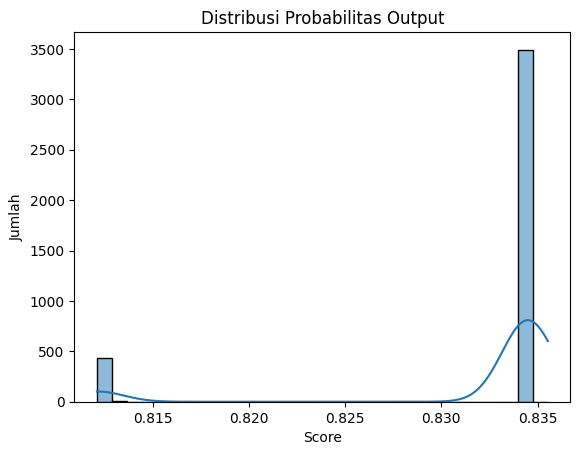

In [ ]:
import seaborn as sns
sns.histplot(y_scores, bins=30, kde=True)
plt.title("Distribusi Probabilitas Output")
plt.xlabel("Score")
plt.ylabel("Jumlah")
plt.show()


## Persamaan Matematika dalam Model RNN

RNN (Recurrent Neural Network) adalah model deep learning yang digunakan untuk memproses **urutan data**, seperti kalimat atau teks ulasan. Keunikan RNN terletak pada kemampuannya untuk **mengingat konteks sebelumnya** melalui _hidden state_.

### 1. Hidden State Update

Pada setiap langkah waktu \( t \), RNN memperbarui hidden state berdasarkan input saat ini \( x_t \) dan hidden state sebelumnya \( h_{t-1} \):

$$
h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$

- \( h_t \): hidden state pada waktu \( t \)  
- \( x_t \): input token pada waktu \( t \)  
- \( W_{xh} \): bobot dari input ke hidden state  
- \( W_{hh} \): bobot dari hidden state sebelumnya  
- \( b_h \): bias untuk hidden layer  
- \( \tanh \): fungsi aktivasi nonlinear (hasil antara -1 dan 1)


### 2. Output Layer (Prediksi)

Setelah seluruh input diproses, hidden state terakhir digunakan untuk menghasilkan output prediksi:

$$
\hat{y} = \sigma(W_{hy} \cdot h_T + b_y)
$$

- \( \hat{y} \): prediksi akhir (probabilitas positif)  
- \( h_T \): hidden state terakhir pada urutan input  
- \( W_{hy} \): bobot dari hidden ke output  
- \( b_y \): bias pada layer output  
- \( \sigma \): fungsi sigmoid, menghasilkan output antara 0 dan 1

### 3. Binary Cross-Entropy Loss

Fungsi loss yang digunakan untuk klasifikasi biner (positif/negatif):

$$
\mathcal{L}_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

- \( y_i \): label sebenarnya (0 atau 1)  
- \( \hat{y}_i \): prediksi probabilitas  
- \( N \): jumlah data

### 4. Backpropagation Through Time (BPTT)

Karena RNN bekerja dengan urutan, proses pelatihan dilakukan melalui **Backpropagation Through Time**, di mana gradien dihitung sepanjang waktu:

$$
\frac{\partial \mathcal{L}}{\partial W} = \sum_{t=1}^{T} \frac{\partial \mathcal{L}}{\partial h_t} \cdot \frac{\partial h_t}{\partial W}
$$

##### Backpropagation dilakukan ke seluruh waktu untuk memperbarui bobot model.
---

# 📐 Persamaan Matematika

### 1. **Binary Cross-Entropy Loss**
Digunakan sebagai fungsi loss untuk klasifikasi biner.

$$
\mathcal{L}_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

- \( y_i \): label asli (0 atau 1)  
- \( \hat{y}_i \): output prediksi (probabilitas dari sigmoid)  
- \( N \): jumlah sampel  
- Tujuan: meminimalkan kesalahan antara prediksi dan label asli

### 2. **Akurasi**
Mengukur jumlah prediksi yang benar dibandingkan total prediksi.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- TP: True Positive  
- TN: True Negative  
- FP: False Positive  
- FN: False Negative

### 3. **Presisi (Precision)**
Seberapa akurat model saat memprediksi kelas positif.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$


### 4. **Recall (Sensitivitas)**
Seberapa baik model mendeteksi semua data yang benar-benar positif.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### 5. **F1 Score**
Rata-rata harmonik antara Precision dan Recall.

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### 6. **ROC Curve & AUC**
ROC (Receiver Operating Characteristic) menunjukkan keseimbangan antara TPR dan FPR.

$$
\text{TPR} = \frac{TP}{TP + FN}, \quad
\text{FPR} = \frac{FP}{FP + TN}
$$

AUC (Area Under Curve) mengukur seberapa baik model membedakan kelas:  
- AUC = 1.0 → sempurna  
- AUC = 0.5 → tidak lebih baik dari tebak-tebakan

---

## 📈 Visualisasi

### ✅ Grafik Loss dan Akurasi
- Kurva loss digunakan untuk melihat performa model dalam mempelajari data.
- Kurva akurasi menunjukkan performa klasifikasi model.

### ✅ ROC Curve
- Digunakan untuk mengevaluasi keseimbangan sensitivitas dan spesifisitas model pada berbagai threshold.
- Semakin melengkung ke kiri atas, semakin baik modelnya.

